# Simulating a bead trajectory
Along with calibrating forces, ``Tweezepy`` also contains methods for simulating bead trajectories.

In a single-molecule force spectroscopy experiment, a bead is well-described by Langevin dynamics: the bead's position, $x$, fluctuates over time, $t$, as it randomly diffuses in a harmonic potential, $E(x) = 1/2\kappa x^2$, where $\kappa$ is the trap stiffness.

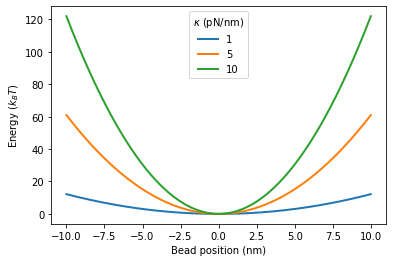

In [3]:
import numpy as np
import matplotlib.pyplot as plt
kappas = np.array([1,5,10])
def energy(x,k):
    kT = 4.1
    return 1/2 * k * x**2 / kT
x = np.linspace(-10,10,num=1000)
for kappa in kappas:
    plt.plot(x,energy(x,kappa),label = kappa,lw=2)
plt.xlabel('Bead position (nm)')
plt.ylabel(r'Energy ($k_BT$)')
plt.legend(title=r'$\kappa$ (pN/nm)')

This plot shows the energy (in $k_BT$) as a function of the bead's position (in nm). Collisions between the bead and water molecules create a stochastic (Langevin) force, $F_L$, that obeys the fluctuation-dissipation relation, $\langle F_L(t+t')F_L(t)\rangle = 2\gamma k_BT\delta(t')$, where $\gamma$ is the drag coefficient and $\delta(t)$ is the Dirac delta function.

For a micron-scale bead in water, inertial effects can become important at sampling rates, $f_s\gtrsim10^6$, well below the sampling rate of most SMFS video-tracking experiments. Thus, the bead's motion is well-described by the overdamped Langevin equation:

$$\kappa x(t) + \gamma \dot{x}(t) = F_L(t)$$


To simulate the bead, we can rewrite the overdamped Langevin equation so that changes in the bead's position, $\Delta x = x(t+t') - x(t)$, are induced by $F_L$ over a simulation time step, $t'$:

$$\Delta x = \frac{\Delta t}{\gamma}\left(F_L(t) - \kappa x(t)\right)$$

$$ x(t+t') = x(t) + \Delta x$$

For each time step, $F_L$ is drawn from a norm distribution with mean, $\langle F_L\rangle = 0$, and variance, $\langle F_L^2\rangle = 2\gamma k_BT\Delta t$.

Text(0, 0.5, 'Bead position (nm)')

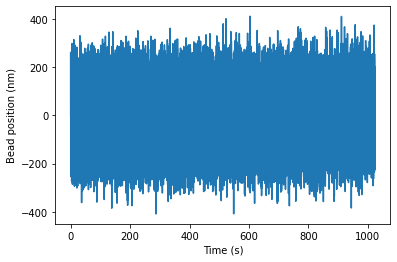

In [4]:
from tweezepy import simulate_trace
fc = 10 # corner frequency
gamma = 1e-5 # dissipation due to viscous drag, in pN s/nm
             # 1e-5 is a typical value for an MT experiment
kappa = gamma*2*np.pi*fc # kappa in pN/nm
fsim = 100 # sampling frequency in Hz
N  = 102400 # number of points in trajectory
seed = 0
time = np.arange(N)/fsim
xtrace = simulate_trace(gamma,kappa,fsim,N, seed = seed)
plt.plot(time, xtrace)
plt.xlabel('Time (s)')
plt.ylabel('Bead position (nm)')

In an actual experiment, the exposure time of the camera will introduce motion blur. To capture this effect, we can downsample the bead trajectory. To accomplish this, we simulate the bead at 1000 times the sampling frequency and then downsample by finding the average position of every 1000 bead positions. This is done automatically in the ``downsampled_trace`` function.

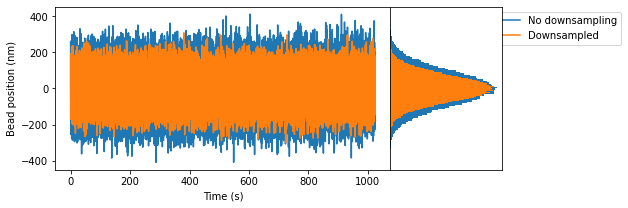

In [5]:
from tweezepy import downsampled_trace
xtrace = simulate_trace(gamma,kappa,fsim,N, seed = seed)
xtrace_ds = downsampled_trace(gamma,kappa,fsim,N, seed = seed)

fig,ax = plt.subplots(figsize=(8,3),
                      ncols=2,
                      gridspec_kw={'width_ratios':[3,1],
                                   'wspace':0})
ax[0].plot(time, xtrace, label = 'No downsampling')
ax[0].plot(time, xtrace_ds, label = 'Downsampled')
ax[1].hist(xtrace,bins=100,orientation = 'horizontal')
ax[1].hist(xtrace_ds,bins=100,orientation = 'horizontal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Bead position (nm)')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].legend(bbox_to_anchor = (1.3,1))

This plot shows that motion blur reduces the variance of the bead positions without shifting the equilibrium bead position. Specifically, the variance of the measured positions with blur, $\text{var}(\bar{x})$ is related to the variance of the bead positions without blur, $\text{var}(x)$, by

$$\text{var}(\bar{x}) = \text{var}(x)S(\alpha)$$

where $\alpha\equiv\tau_0\kappa/\gamma$ and $\tau_0$ is the camera integration time. The motion blur correction, $S(\alpha)$, is

$$S(\alpha)= \frac{2}{\alpha} - \frac{2}{\alpha^2}\left(1-\exp(-\alpha)\right)$$

The motion blur affects the power spectral density (PSD) at high frequencies and Allan variance (AV) at short observation times.

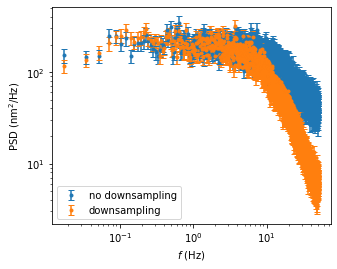

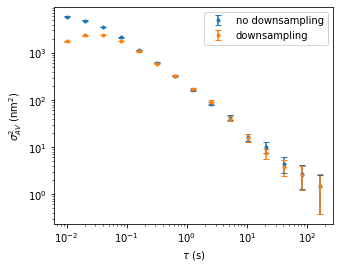

In [6]:
from tweezepy import AV,PSD
psd = PSD(xtrace,fsim,bins = 35)
fig, axes = psd.plot(data_label='no downsampling')
psd = PSD(xtrace_ds,fsim,bins = 35)
fig, axes = psd.plot(fig=fig,data_label='downsampling')
axes[0].legend()
av = AV(xtrace,fsim)
fig, axes = av.plot(data_label='no downsampling')
av = AV(xtrace_ds,fsim)
fig, axes = av.plot(fig=fig,data_label='downsampling')
axes[0].legend()